In [1]:
import jieba
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from transformers import BertTokenizer, BertModel

In [6]:
directory = "../dat/ÁîúÈªû"
all_comments = []

# ÈÅçÊ≠∑ÁõÆÈåÑ‰∏≠ÁöÑÊâÄÊúâÊñá‰ª∂
file_names = os.listdir(directory)
for file_name in file_names:
    file_path = os.path.join(directory, file_name)
    if not os.path.isfile(file_path): continue
    if not file_path.endswith('.json'): continue
    if os.path.getsize(file_path) == 0: continue
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)
            comments = data.get('comments', [])
            all_comments.extend(comments)
    except: 
        print("something wrong in "+file_path)

print(len(all_comments))

26087


In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
model = BertModel.from_pretrained('bert-base-chinese')

In [6]:
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    return torch.mean(last_hidden_states, 1).squeeze().detach().numpy()

In [7]:
df = pd.DataFrame(all_comments)
df = df.drop(columns='other').dropna(subset=['comment'])

In [8]:
# ÂàùÂßãÂåñÁ©∫ÂàóË°®‰æÜÂ≠òÂÑ≤ÂµåÂÖ•
embeddings = []

# ‰ΩøÁî®tqdmÈ°ØÁ§∫ÈÄ≤Â∫¶Ê¢ù
for comment in tqdm(df['comment'], desc="Calculating BERT embeddings"):
    # Â∞çË©ïË´ñÈÄ≤Ë°åÂàÜË©ûÔºåÂÖàÈÄ≤Ë°åÈ°ûÂûãÊ™¢Êü•ÂíåËôïÁêÜ
    embedding = get_bert_embedding(comment)
    embeddings.append(embedding)

# Â∞áÂµåÂÖ•Ê∑ªÂä†Âà∞Êï∏ÊìöÊ°Ü
df['bert_embedding'] = embeddings

Calculating BERT embeddings: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 21627/21627 [14:18<00:00, 25.20it/s]


In [9]:
X = np.vstack(df['bert_embedding'].values)

Using ***Principal Component Analysis (PCA)*** method

In [19]:
reduced_X = PCA(n_components=2).fit_transform(X)

/var/folders/ql/_w19z0t509qf1m5dl7qqzjmc0000gn/T/ipykernel_49132/1120710779.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_X[:, 0], reduced_X[:, 1], cmap='jet', s=0.1)


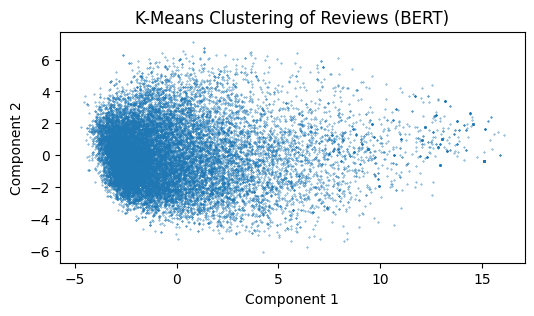

In [23]:
# Áπ™Ë£ΩÁµêÊûú
fig = plt.figure(figsize=(6, 3))
plt.scatter(reduced_X[:, 0], reduced_X[:, 1], cmap='jet', s=0.1)
plt.title('K-Means Clustering of Reviews (BERT)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

Using ***Elbow Method*** by observing the relation between **Sum of Squared Errors** and **Cluster number**

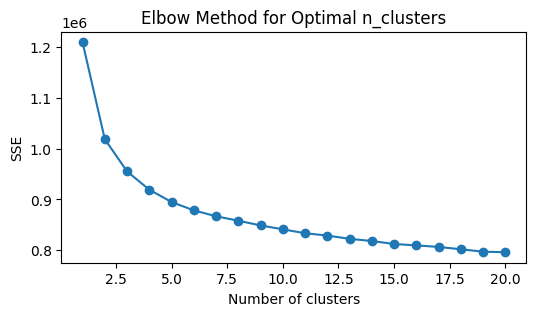

In [25]:
# ‰ΩøÁî®ËÇòÈÉ®Ê≥ïÂâáÁ¢∫ÂÆöÊúÄ‰Ω≥ÁöÑËÅöÈ°ûÊï∏Èáè
sse = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# Áπ™Ë£ΩËÇòÈÉ®Ê≥ïÂâáÂúñ
fig = plt.figure(figsize=(6, 3))
plt.plot(range(1, 21), sse, marker='o')
plt.title('Elbow Method for Optimal n_clusters')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

Using K-Means to classify the comment

In [30]:
# ‰ΩøÁî® K-means ÈÄ≤Ë°åËÅöÈ°û
kmeans = KMeans(n_clusters=4, random_state=23)
df['cluster'] = kmeans.fit_predict(X)

In [31]:
sil_score = silhouette_score(X, df['cluster'])
print(f"Silhouette Score: {sil_score}")

Silhouette Score: 0.09305884689092636


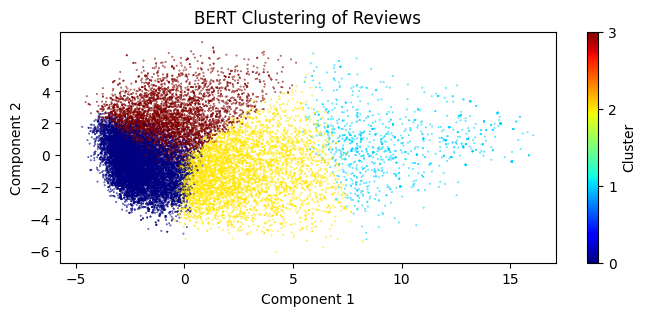

In [36]:
# Áπ™Ë£ΩÁµêÊûú
fig = plt.figure(figsize=(8, 3))
plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=df['cluster'], cmap='jet', s=0.1)
plt.title('BERT Clustering of Reviews')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Cluster', ticks=np.arange(df['cluster'].min(), df['cluster'].max() + 1))
plt.show()

In [107]:
df[df['cluster'] == 0]

author                                            comment  \
0      TZU-HSUAN CHUANG  ÈÄôÈñì ÊúâÈå¢‰πüË≤∑‰∏çÂà∞\nÁáü‰∏çÁáüÊ•≠ Âú®‰∏çÂú®ÈÄôË£°Êì∫\nÂÖ®ÈÉ®ÁúãËÄÅÈóÜÂøÉÊÉÖÂïäÂïäÂïäÂïäÂïäÔºÅ\nÂ¶≥ÁÑ°Ë´ñÊÄéÈ∫ºÂïè ...   
1         chelsea chang  1.ÁÖßÁâáÂè≥ÈÇäÁöÑÊòØÊ≠§ÂÆ∂Â∫óÁöÑÔºåÂ∑¶ÈÇäÊòØÂú®Êù±Â∏ÇÂ†¥Ë£°Ë≤∑ÁöÑ„ÄÇ2.ÂÉπÊ†ºÈÉΩÊòØ$20„ÄÇ3.ÂèØÁúãÂá∫ÔºåÂè≥ÈÇäÁöÑËºÉÈÄèÊòé...   
2             sho micky                       Á∂†Ë±ÜÈú≤ÈõñÁÑ∂ÊúâÈªûÁîú‰ΩÜÂ•ΩÂêÉ\nÈÇÑÊúâËèúÁáï ÁèæÂú®ÂæàÈõ£ÂêÉÂà∞ÂÇ≥Áµ±ÈªûÂøÉ   
3                Arlene  Â•ΩÂêÉÔºåËÄå‰∏î‰∏çÊúÉÂæàÁîúÔºåÂ∞±ÊòØÂ∞èÊôÇÂÄôË®òÊÜ∂‰∏≠ÁöÑÂë≥ÈÅìÔºÅÊó©Ëµ∑ÁöÑÈ≥•ÂÖíÊúâËü≤ÂêÉÔºåË≥£ÂÆåÂ∞±Êî∂Êî§‰∫ÜÔºåÂ§™ÊôöÂéªÊúÉÊí≤Á©∫ÂñîÔºÅ...   
4            Yuehua Wun                              Âè§Êó©Âë≥Èõ∂Ë≤†ÊìîÂ∞èÈªûÂøÉÔºåÂÜ∞ÂÜ∞Ê∂ºÊ∂ºÂèàÊ∏ÖÁîúÔºåÈäÖÊùøÂÉπ   
...                 ...                                                ...   
26072     Dabo Ann Wang                 Â§æÈ§°ÁîúÂúàË∂ÖÁ¥öÂ•ΩÂêÉüíì ‰∏ÄÂÆöË¶ÅÂõûË®™„ÅÆÈõûËõãÁ≥ïÔºÅËÄÅÈóÜÂ®òË¶™ÂàáÁ¨ëÂÆπÊúâÂ§†QÂèØÊÑõÔΩûÔΩû   
26073               Ë¨ùËä∑Ëä∏         ÂæûÊ≤íÊúâÂØ¶È´îÂ∫óÈù¢ÊôÇÂ∞±ÊúâÂêÉÈÅéÔºÅÂ§æÈ§°ÁîúÁîúÂúàÈÇÑÊòØÂæàÂ•ΩÂêÉÔºÅÔºà‰ΩÜÁîúÁîúÂúàË¶ÅÂÖàÈ†êÂÆöËÄå‰∏îÂè™ÊúâÂÖ≠Êó•‰∏ÄÊúâÔºâ   
26075               Èô≥ÈÉÅÂ©ï  Ë∂ÖÊé®Ëñ¶ËèáËèáÂè£Âë≥ÔºåÂéüÊú¨‰ª•ÁÇ∫ÊúÉ‰∏çÊê≠ÔºåÁµêÊûúË∂ÖÂ•ΩÂêÉÁöÑ\nÂÖ∂‰ªñÂè£Âë≥ÊúâÂæàÊ£íÂñî!\nÈóÜÂ®ò‰∫∫ÂæàÂ•ΩÔºåÂÄºÂæóÊé®Ëñ¶ÁöÑ!!!   
26084               Ê•äÊò†ÂΩ§  ËÄÅÈóÜ‰∫∫Ë∂ÖÂ•Ωü•πÊú¨‰æÜÊòØË∑ØÈÅéË¶ÅË≤∑Ë±ÜËä±ÔºåÁµêÊûúÊÉ≥ÂêÉÁöÑËäãÂúìË∑üÁ≤âÁ≤øÈÉΩÊ≤íÊúâ‰∫Üü§£Ëá®Ëµ∞ÂâçÂ∞±Ë¢´ËÄÅÈóÜÂ°û‰∫Ü‰∏âÂÄãËªäËº™È§ÖË™™...   
26085             Katya       Èªû‰∫ÜÂèØ‰ª•Êåë5Ê®£ÊñôÁöÑÁ∂úÂêàÂÜ∞ 50Â°ä\nÊØèÊ®£ÊñôÈÉΩÂæàÂ§©ÁÑ∂ ÂæàÂñúÊ≠°\nÂèØ‰ª•ÊÑüË¶∫ÂæóÂá∫ËÄÅÈóÜÁöÑÁî®ÂøÉÔºÅÊé®   

       star                                     bert_embedding  cluster  \
0         5  [0.7907704, 0.023078535, -0.14742005, 0.424830...        0   
1         3  [0.8116879, -0.17959112, -0.09079031, 0.342416...        0   
2         5  [0.3545232, 0.0881715, -0.3533192, 0.2761139, ...        0   
3         5  [0.6608559, 0.11536657, -0.23615138, 0.3409125...        0   
4         5  [1.3575766, -0.09089799, -0.68242705, 0.071478...        0   
...     ...                                                ...      ...   
26072     5  [0.4359396, -0.13295089, -0.08643657, 0.296447...        0   
26073     5  [0.5504194, 0.022974672, -0.36029813, 0.431238...        0   
26075     5  [1.0694582, -0.08331302, -0.50844276, 0.444796...        0   
26084     5  [0.5346007, 0.04079232, -0.39634466, 0.4622274...        0   
26085     5  [1.0849622, 0.040818274, -0.29453233, 0.504484...        0   

       anomaly-0.05  
0                 1  
1                 1  
2                 1  
3                 1  
4                 1  
...             ...  
26072             1  
26073             1  
26075             1  
26084             1  
26085             1  

[11243 rows x 6 columns]

In [108]:
df[df['cluster'] == 1]

author  comment  star  \
424       Hanna Lin   ËàíÊúçÁöÑÂ∞èÂ§©Âú∞     5   
425             Èô≥Êò±ÂÆè      ÂâõÂ•ΩÁîú     5   
605            Tony     ÁîúÈªûÂ•ΩÂêÉ     5   
648       Lovi Chen  Ê†∏ Ê°É Â•Ω Â§ö     5   
654    Lester790416    Â∑¥ÊñØÂÖãÂ•ΩÂêÉ     5   
...             ...      ...   ...   
26051           Èô≥ÊòéË±ê     ÈùûÂ∏∏Â•ΩÂêÉ     5   
26052           Á∞°ÊπòÁé≤       Â•ΩÂêÉ     5   
26053           ‰∫éÈ∫óÂ®ü      Â•ΩÂêÉüòã     5   
26055    Jaime bien     Ë†ªÈ†ÜÂè£ÁöÑ     5   
26080  Yu Zheng Lin  ÈõûËõãÁ≥ïËï≠ÂñùÂÅáÔºÅ     5   

                                          bert_embedding  cluster  \
424    [0.32577178, -0.66701627, 0.12032307, 0.049793...        1   
425    [-0.21821089, 0.6031839, -0.76160157, 0.365178...        1   
605    [0.08686171, 0.48735598, -1.165585, 0.29892156...        1   
648    [0.2152714, -0.19484432, -0.58333695, 0.512266...        1   
654    [-0.71486026, -0.05168392, -1.3288628, 0.35432...        1   
...                                                  ...      ...   
26051  [-0.49180555, 0.43161437, -0.6568874, 0.016972...        1   
26052  [-0.46534622, 0.3548276, -1.3464688, 0.4188956...        1   
26053  [-0.49815893, 0.4154939, -1.202735, 0.19725771...        1   
26055  [0.50571084, 0.53387624, -0.24936604, 0.515955...        1   
26080  [0.04861349, 0.7263007, -0.18510103, 0.6953847...        1   

       anomaly-0.05  
424              -1  
425              -1  
605               1  
648               1  
654               1  
...             ...  
26051             1  
26052            -1  
26053            -1  
26055             1  
26080             1  

[1355 rows x 6 columns]

In [109]:
df[df['cluster'] == 2]

author                             comment  star  \
6      Simon Shih  Â•ΩÂêÉÁöÑËèúÁáïÔºàÊ¥ãËèúÂáçÔºâ„ÄÅÁ∂†Ë±ÜÈú≤„ÄÅÊùè‰ªÅÈú≤„ÄÅÁ∂†Ë±ÜÁ≤âÁ≤ø„ÄÇÈÉΩÊòØÂè§Êó©Âë≥Â∞èÂêÉÁîúÈªû„ÄÇ     5   
7            „Ç´„ÇØ„ÉÜ„É´               Á∂†Ë±ÜÈú≤Â•ΩÂ•ΩÂêÉ\nÊØèÂ§©Êó©‰∏ä9Èªû‰æÜÔºåË≥£ÂÆåÂ∞±Ê≤í‰∫Ü     5   
9              ·Ñã·Ñè                           ÊúâÂ§†ËÆö Â∞èÊôÇÂÄôÂõûÊÜ∂     5   
50            ÂäâÁßãÊÉ†                 ÁâπÂà•ÁöÑÂÜ∞Â∫ó‰ΩøÁî®Ê°ÇÂúìË£ΩÁ≥ñÊ∞¥\nÊñôÂ•ΩÂØ¶Âú®Âñî     5   
74     Vito Huang                           ‰æøÂÆúÂ§ßÁ¢óÔºåÊñôÂ§öÂØ¶Âú®     5   
...           ...                                 ...   ...   
26074          ÊûóÊ∑≥         ÊúâÈ§°ÁöÑÈõûËõãÁ≥ïËàáÁúæ‰∏çÂêåÔºåÈ¶ôQÊøÉ‚ãØÂ•ΩÂêÉ\nËÄÅÈóÜÂèØÊÑõÁ¨ëÂÆπÂèØÊé¨     5   
26076         ÈòÆÁõàËªí                Ë∂ÖÔΩûÔΩûÔΩûÂ•ΩÂêÉüòã\nÊúÄÂñúÊ≠°ÈªëÁ≥ñÈ∫ªÁ≥¨ÁáíÂè£Âë≥ÔºÅ     5   
26077   Lunn Wang                       ÈõûËõãÁ≥ïÂæàÁæéÂë≥ ‰∏ãÂçàËå∂Â•ΩÈÅ∏Êìá     5   
26079         ÊûóÊòéÂÆè                       Êù±Ë•øÂ•ΩÂêÉüòã ÊúÄÊÑõËä±Áîü‰ªÄÈ∫ºÊÄù     5   
26081         ÈÉ≠Á©éÈå°                              Ë∂ÖÂ•ΩÂêÉüòãÊé®Êé®     5   

                                          bert_embedding  cluster  \
6      [0.797213, -0.05290244, -0.4321325, 0.3947856,...        2   
7      [0.46473223, -0.07865059, -0.3805427, 0.636548...        2   
9      [0.10787636, 0.3713377, 0.2484924, 0.38750345,...        2   
50     [0.8016275, 0.07317603, -0.3852412, 0.65518963...        2   
74     [0.27556956, 0.12751834, -1.2389795, 0.599489,...        2   
...                                                  ...      ...   
26074  [0.76491314, 0.21726407, -0.47885227, 0.268987...        2   
26076  [0.37280875, 0.13140117, -0.5097524, 0.814936,...        2   
26077  [0.41074124, 0.38873369, -0.5808248, 0.3942759...        2   
26079  [0.20469591, 0.045717917, -0.68972546, 0.19226...        2   
26081  [0.12110405, 0.10540584, -0.8134515, 0.6522926...        2   

       anomaly-0.05  
6                 1  
7                 1  
9                -1  
50                1  
74                1  
...             ...  
26074             1  
26076             1  
26077             1  
26079             1  
26081             1  

[4640 rows x 6 columns]

In [110]:
df[df['cluster'] == 3]

author                                     comment  star  \
34                 ËÉ°Âª∑ÂÄ´       ËúúÂú∞ÁìúÂíåÂÜ∞ÈÉΩË∂ÖÁ¥öÂ•ΩÂêÉ ËÄå‰∏îÂÉπÊ†º‰πü‰∏çË≤¥\nÂÖßÁî®ÁöÑË©±Âè™ÊúâÊóÅÈÇäÁöÑÊú®Ê°åÊ§Ö ‰ΩçÂ≠ê‰∏çÂ§ö     5   
49          JOSH TSENG        ËÄÅÂ±ãüèöÔ∏èÂêÉÂÜ∞\n‰ªΩÈáèÂæàÂ§†\nÂ∫óÂÆ∂ÈÇÑÂæàË≤ºÂøÉËÉΩÂ§†Ë™øÊï¥ÁîúÂ∫¶\nÊÖãÂ∫¶‰πüÈùûÂ∏∏Ë¶™Âàáüòç     5   
63                  Êø†Êø†  ËúúÂú∞ÁìúÂæàÊôÆÈÄö\nÂÜ∞ÂìÅÈÉ®‰ªΩ‰πüÂæàÊôÆ\nÂì°Â∑•ÁúãËµ∑‰æÜË†ªÂ§öÁöÑ\n‰ΩÜÂá∫È§êÂæàÊÖ¢ .. Ë∂ÖÁ¥öÊÖ¢ ..     1   
73                 Ë≤ìÂí™Á∞°                        Âè§Êó©Âë≥üëçÊù±Ë•øÂ•ΩÂêÉ\n‰∫∫Âì°‰πüÂæàÁÜ±ÊÉÖ‚ù§Ô∏è‚Äçüî•     5   
98              Edward         Áî®ÊñôÈÇÑ‰∏çÈåØÔºå‰∏çÊúÉÂ§™Ë≤¥„ÄÇÂÖßÁî®ÂçÄÂú®Êà∂Â§ñÔºåÊòØÊú®È†≠ÁöÑÊ°åÊ§Ö„ÄÇ‰∏çÈÅéÂÅúËªäÊ≤íÈÇ£È∫ºÂ•ΩÂÅú„ÄÇ     5   
...                ...                                         ...   ...   
25950    Andrew Glossa            ÂñùÊùØÂíñÂï°ÂíåÂêÉË±ÜÂ≠êÁöÑÂ•ΩÂú∞Êñπ„ÄÇËÄÅÈóÜÂíåÂì°Â∑•ÈÉΩÂæàÂèãÂñÑÔºåÁÉòÁÑôÊ©üÁöÑÂë≥ÈÅìÂæàÈ¶ô„ÄÇ     5   
25951     Yi-Chen Chen                           ÂíñÂï°‰∏çÈåØÔºå‰ΩÜÁîúÈªû‰∏çÂ§™‰ª§‰∫∫Âç∞Ë±°Ê∑±Âàª„ÄÇ     3   
25955  Barb Rebentisch                                  ËàíÈÅ©ÔºåÈÇÑÊúâÂæàÊ£íÁöÑÂíñÂï°     5   
26045              ÊπòÁæöË®±                            Áí∞Â¢ÉËàíÈÅ©Â•ΩÂÅúËªäÔºåÈóÜÂ®ò‰∫∫ÂæàÂÆ¢Ê∞£Âì¶ÔºÅ     5   
26078              ÂΩ≠Áé≤Áë§                               ÂæàÂñúÊ≠°ÂæàÂ•ΩÂêÉÔºåÊúÉ‰ªãÁ¥πÊúãÂèãÂéª     5   

                                          bert_embedding  cluster  \
34     [0.47110242, -0.09935813, -0.4778668, 0.571784...        3   
49     [0.74427474, 0.05878522, -0.020177163, 0.32041...        3   
63     [0.8520848, -0.084068134, -0.5451445, 0.539605...        3   
73     [0.7738014, 0.17019112, -0.31462482, 0.3129341...        3   
98     [0.41200307, 0.08179377, -0.092106804, 0.62253...        3   
...                                                  ...      ...   
25950  [0.6736533, -0.019636277, -0.20711072, 0.25794...        3   
25951  [0.6045334, 0.42817923, -0.3870663, 0.25193253...        3   
25955  [0.24928765, 0.46636567, 0.15910941, 0.1578137...        3   
26045  [0.72952664, -0.19272584, -0.2791007, 0.678403...        3   
26078  [0.31351212, -0.18056463, -0.45397103, 0.52428...        3   

       anomaly-0.05  
34                1  
49                1  
63                1  
73                1  
98                1  
...             ...  
25950             1  
25951             1  
25955             1  
26045             1  
26078             1  

[4389 rows x 6 columns]

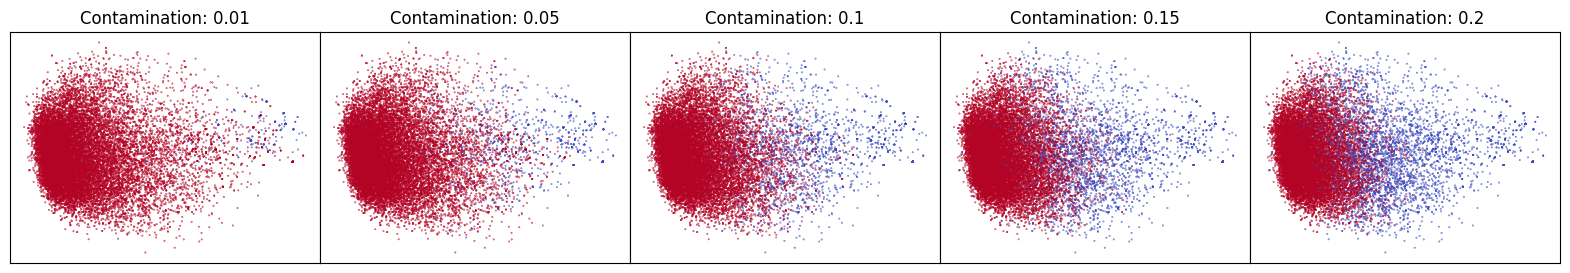

In [52]:
contamination_values = [0.01, 0.05, 0.1, 0.15, 0.2]
anomaly_results = {}

for contamination in contamination_values:
    isolation_forest = IsolationForest(contamination=contamination, random_state=42)
    df['anomaly'] = isolation_forest.fit_predict(X)
    anomaly_results[contamination] = df['anomaly']

# ÂèØË¶ñÂåñ‰∏çÂêå contamination ÂÄº‰∏ãÁöÑÁµêÊûú
fig, axes = plt.subplots(1, len(contamination_values), figsize=(20, 3), sharex=True, sharey=True)
for i, contamination in enumerate(contamination_values):
    axes[i].scatter(reduced_X[:, 0], reduced_X[:, 1], c=anomaly_results[contamination], cmap='coolwarm', s=0.1)
    axes[i].set_title(f'Contamination: {contamination}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.subplots_adjust(wspace=0)
plt.show()

In [137]:
# ‰ΩøÁî®Isolation ForestÈÄ≤Ë°åÁï∞Â∏∏Ê™¢Ê∏¨
contamination = 0.02
isolation_forest = IsolationForest(contamination=contamination, random_state=42)
df[f'anomaly-{contamination}'] = isolation_forest.fit_predict(X)# ‰ΩøÁî®Isolation ForestÈÄ≤Ë°åÁï∞Â∏∏Ê™¢Ê∏¨

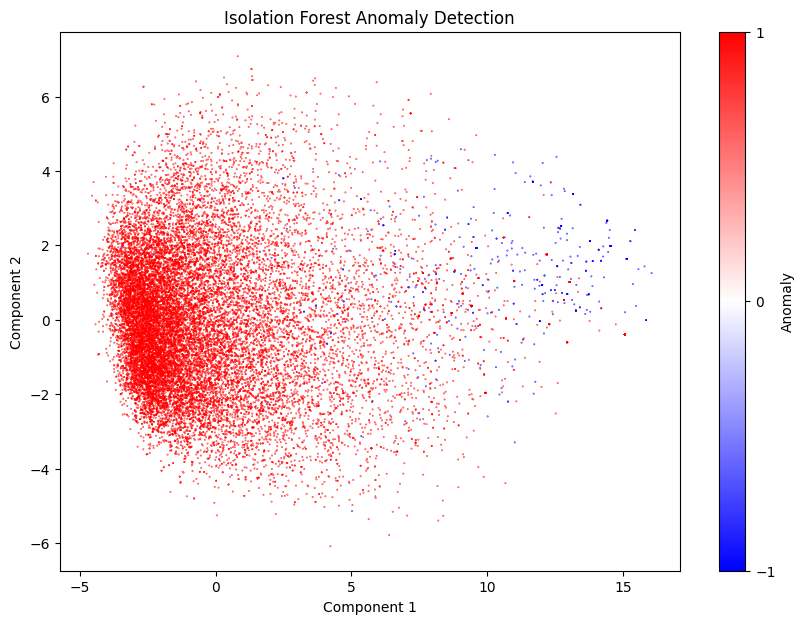

In [138]:
plt.figure(figsize=(10, 7))
plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=df[f'anomaly-{contamination}'], cmap='bwr', s=0.1)
plt.title('Isolation Forest Anomaly Detection')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Anomaly', ticks=np.arange(df[f'anomaly-{contamination}'].min(), df['anomaly-0.05'].max() + 1))
plt.show()

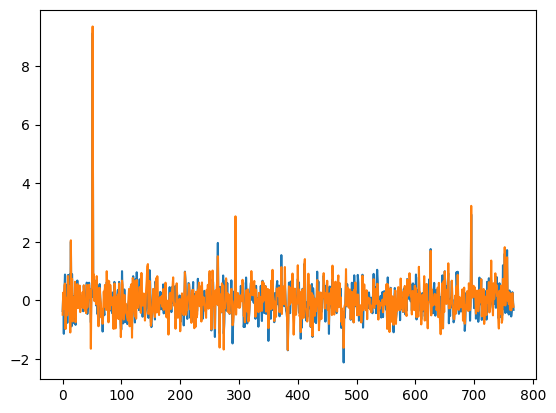

In [136]:
# texts = ["Â•ΩÂêÉ", "Â•ΩÂ•ΩÂêÉ", "ÂæàÂ•ΩÂêÉ", "Â•ΩÂ•ΩÂêÉÂì¶", "Ë∂ÖÂ•ΩÂêÉ", "Ë∂ÖÂ•ΩÂêÉÁöÑüòã"]
texts = ["Â•ΩÂ•ΩÂêÉ", "Â•ΩÂ•ΩÁó¥"]
t_texts = []
for text in texts:
    t_text = get_bert_embedding(text)
    t_texts.append(t_text)
    plt.plot(t_text)
plt.show()

In [131]:
sum(t_texts[0]-t_texts[1])

-1.3796813730150461

In [139]:
anomalies = df[df[f'anomaly-{contamination}'] == -1]

# Ë®àÁÆóÊØèÂÄãÁï∞Â∏∏Ë©ïË´ñÁöÑÂá∫ÁèæÊ¨°Êï∏
anomaly_counts = anomalies['comment'].value_counts()

# ÊåâÂá∫ÁèæÊ¨°Êï∏ÂàÜÁµÑË©ïË´ñ
grouped_comments = {}
for comment, count in anomaly_counts.items():
    if count not in grouped_comments:
        grouped_comments[count] = []
    grouped_comments[count].append(comment)

# ÊâìÂç∞ÁµêÊûú
for count, comments in sorted(grouped_comments.items())[::-1]:
    print(f"Count {count} : {comments}")

Count 25 : ['ËÆö']
Count 12 : ['ÂæàÊ£í', 'üëç ‚Ä¶']
Count 9 : ['Â•ΩÁöÑ']
Count 8 : ['‰∏çÈåØ']
Count 7 : ['üëçüèª ‚Ä¶', '‰∏çÈåØÂêÉ', 'ÂæàËÆö']
Count 6 : ['ÈÇÑ‰∏çÈåØ']
Count 5 : ['Ë∂ÖËÆö']
Count 4 : ['ÊôÆÈÄö', 'üëçüëçüëç ‚Ä¶', 'Ë∂ÖÊ£í', 'Â•Ω„Ñò', 'ÂæàÈ¶ô']
Count 3 : ['ÈÇÑË°å', 'ÁæéÂë≥', 'ÂñúÊ≠°', 'Ê∫´È¶®', 'ËÆöËÆöËÆö', 'Êé®', 'ÊôÆÊôÆÈÄöÈÄö']
Count 2 : ['ËÆöÂñî', 'Ê£íÔºÅ', 'ÊÇ†Èñí‰∫´Âèó', 'ÁâπÂà•', 'ËÄÅÁâåÂêçÂ∫ó ÔºÅ', 'ÁæäÁæπ', 'ÈÇÑÂèØ', 'üÜó ‚Ä¶', 'ÁúüÊùêÂØ¶Êñô', 'Â•ΩÈ¶ô', 'Áµï‰∫Ü', 'ÈΩÅÁî≤', 'üëç', '‰∫îÊòüÂêπÊçßÊé®Êé®', 'ÊôÆÊôÆ', 'ÊòéÂáÄÈõÖÈó¥ÔºåÁôΩÁµúÂ±Ä‰Ωà„ÄÇ', 'Á®±ËÆö', 'Áâ©ÁæéÂÉπÂªâÔºåÁâ©Ë∂ÖÊâÄÂÄº', 'Â•ΩÂú∞Êñπ', 'ÁæéÁæéË∫Ç^^', 'üëåüèΩ(‚óè¬∞u¬∞‚óè)üëçüèæ', 'Â∞èÈõÖÂ±ÄÊ†ºÔºåÈùôÊ∑ëÈÄ∏ÁÑ∂„ÄÇ', 'ÈÉΩÂ•ΩÂ•ΩÂêÉ(À∂‚Äæ·∑Ñ ‚ÅªÃ´ ‚Äæ·∑ÖÀµ)', 'Â∫ïÁ≤íÁ©¥ÊñØÔΩû', 'üòä ‚Ä¶', 'ÈÄôÊòØ‰∏ÄÁ®ÆÁæé', 'ÂÑ™ÁßÄ', 'ËÆöËÆöüëç ‚Ä¶', 'Â∑ÆÂº∑‰∫∫ÊÑè', '„ÄÇ„ÄÇ„ÄÇ', 'Â•Ω', 'ÈùûÂ∏∏ÁöÑËõã', 'Âè£Ë¢ãÂêçÂñÆÔºÅÔºÅÔºÅ', 'Êé®Êé®', 'ü§§üíó', 'ÊÖãÂ∫¶Ê¨†‰Ω≥', 'üêü', 'ÂïèüòÑ', 'ÂæàÂ•Ω', '‰æøÂÆú', 'ËÆöËÆö', 'ÈØõ

In [76]:
# Â∞áDataFrameÂ≠òÂÑ≤ÁÇ∫JSONÊñá‰ª∂
# df.to_json('clustered_reviews.json', orient='records', force_ascii=False)